In [ ]:
!pip install diffusers transformers torch dlib opencv-python-headless matplotlib

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2024-12-10 13:47:21--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  16.9MB/s    in 3.6s    

2024-12-10 13:47:25 (16.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from google.colab import files

print("Upload your image (face):")
face_file = files.upload()
face_path = list(face_file.keys())[0]

print("Upload base image (e.g., a king body):")
base_file = files.upload()
base_path = list(base_file.keys())[0]

Upload your image (face):


Saving z.JPG to z (1).JPG
Upload base image (e.g., a king body):


Saving soldier1.jpg to soldier1.jpg


In [ ]:
face_image = cv2.imread(face_path)
base_image = cv2.imread(base_path)

# Convert images to RGB for display purposes
face_image_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [ ]:
def get_landmarks(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
      raise ValueError("No faces detected in the image.")
    landmarks = predictor(gray, faces[0])
    return np.array([(p.x, p.y) for p in landmarks.parts()])

face_landmarks = get_landmarks(face_image, detector, predictor)
base_landmarks = get_landmarks(base_image, detector, predictor)

In [ ]:
def align_face(source_image, source_points, target_points, output_shape):
    M, _ = cv2.estimateAffinePartial2D(source_points, target_points)
    return cv2.warpAffine(source_image, M, (output_shape[1], output_shape[0]))

aligned_face = align_face(face_image, face_landmarks, base_landmarks, base_image.shape)

In [ ]:
def create_face_mask(image, landmarks):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    convex_hull = cv2.convexHull(landmarks)
    cv2.fillConvexPoly(mask, convex_hull, 255)
    return mask

face_mask = create_face_mask(base_image, base_landmarks)

In [ ]:
center = tuple(np.mean(base_landmarks, axis=0, dtype=int))
blended_image = cv2.seamlessClone(
    aligned_face, base_image, face_mask, center, cv2.NORMAL_CLONE
)

In [ ]:
model = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
#model.to("cuda")  # Use GPU if available

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompt=("A soldier in a battle field.")
generated_image = model(prompt).images[0]
generated_image = np.array(generated_image)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Resize blended image to match the generated background
blended_resized = cv2.resize(blended_image, (generated_image.shape[1], generated_image.shape[0]))

# Combine blended face and generated background
final_result = cv2.addWeighted(generated_image, 0.7, blended_resized, 0.3, 0)

In [ ]:
cv2.imwrite("final_result.png", cv2.cvtColor(final_result, cv2.COLOR_RGB2BGR))


True

In [ ]:
def align_face_safe(source_image, source_points, target_points, output_shape):
    """
    Safely align face using an affine transformation.
    """
    # Validate points before proceeding
    if len(source_points) < 3 or len(target_points) < 3:
        raise ValueError("At least 3 points are required for affine transformation.")

    if len(source_points) != len(target_points):
        raise ValueError("Source points and target points must have the same number of points.")

    # Attempt to compute the affine transformation matrix
    M, status = cv2.estimateAffinePartial2D(np.array(source_points), np.array(target_points))

    if M is None:
        raise ValueError("Failed to compute affine transformation matrix.")

    # Print the matrix for debugging
    print("Affine Transformation Matrix:\n", M)

    return cv2.warpAffine(source_image, M, (output_shape[1], output_shape[0]))

# Call the alignment function inside try-except block
try:
    aligned_face = align_face_safe(face_image, face_landmarks, base_landmarks, base_image.shape)
except ValueError as e:
    print(f"Error during face alignment: {e}")


Affine Transformation Matrix:
 [[ 0.2937317   0.02769026 23.42887389]
 [-0.02769026  0.2937317  14.64932628]]


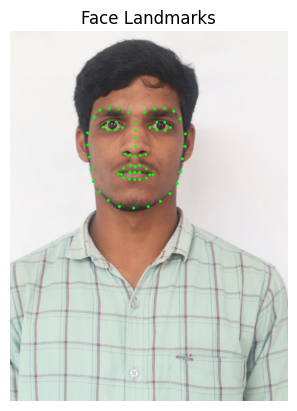

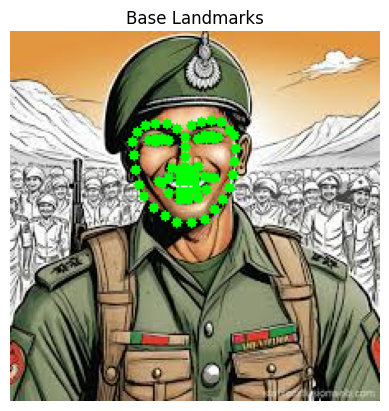

In [ ]:
def visualize_points(image, points, title="Points"):
    """
    Visualize points on the image for debugging.
    """
    temp_image = image.copy()
    for (x, y) in points:
        cv2.circle(temp_image, (x, y), 3, (0, 255, 0), -1)

    plt.imshow(cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Visualize the points for both face and base images
visualize_points(face_image, face_landmarks, "Face Landmarks")
visualize_points(base_image, base_landmarks, "Base Landmarks")


In [ ]:
print("Face Landmarks:", face_landmarks)
print("Base Landmarks:", base_landmarks)


Face Landmarks: [[160 211]
 [161 236]
 [164 261]
 [167 287]
 [172 312]
 [184 334]
 [203 351]
 [226 364]
 [256 367]
 [286 364]
 [311 353]
 [331 337]
 [346 316]
 [353 292]
 [357 265]
 [362 239]
 [363 213]
 [174 179]
 [186 164]
 [205 160]
 [225 161]
 [245 168]
 [279 168]
 [299 161]
 [320 160]
 [339 166]
 [352 182]
 [260 191]
 [260 206]
 [259 222]
 [259 239]
 [238 255]
 [248 257]
 [258 260]
 [269 258]
 [281 256]
 [192 199]
 [203 189]
 [220 189]
 [233 200]
 [218 204]
 [202 205]
 [289 200]
 [304 189]
 [320 189]
 [332 200]
 [321 206]
 [304 205]
 [224 296]
 [235 285]
 [249 279]
 [259 282]
 [268 279]
 [282 286]
 [296 298]
 [282 305]
 [268 308]
 [258 308]
 [247 307]
 [235 304]
 [230 297]
 [248 293]
 [258 293]
 [268 293]
 [289 298]
 [268 293]
 [258 294]
 [248 292]]
Base Landmarks: [[ 74  67]
 [ 75  75]
 [ 76  84]
 [ 78  93]
 [ 81 100]
 [ 87 107]
 [ 94 112]
 [101 116]
 [110 116]
 [118 114]
 [124 108]
 [129 102]
 [133  95]
 [135  87]
 [136  79]
 [137  71]
 [136  63]
 [ 77  61]
 [ 82  57]
 [ 88  56]

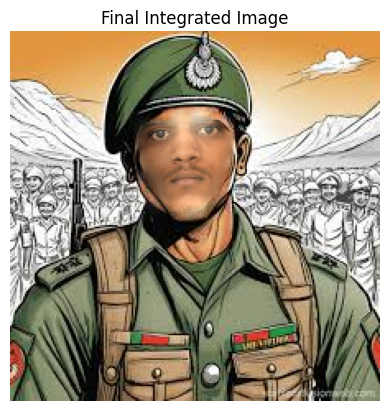

In [ ]:
try:
    center = tuple(np.mean(base_landmarks, axis=0, dtype=int))
    blended_image = cv2.seamlessClone(
        aligned_face, base_image, face_mask, center, cv2.NORMAL_CLONE
    )
except Exception as e:
    print(f"Error during seamless cloning: {e}")

# Final Image
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.title("Final Integrated Image")
plt.axis("off")
plt.show()